# 03 – Deteção de Doenças com Visão Computacional (CNN simples)

Este notebook tem como objetivo treinar um modelo de deep learning para detetar doenças em imagens de videira (míldio, oídio, escoriose) utilizando as imagens sintéticas geradas no notebook anterior.

**Etapas:**
1. Carregar e explorar o dataset de imagens.
2. Preparar os dados para treino (divisão treino/validação/teste, aumentação).
3. Construir uma CNN simples (em vez de EfficientNet, devido ao tamanho do dataset).
4. Treinar o modelo.
5. Avaliar o desempenho (matriz de confusão, precisão, recall).
6. Guardar o modelo para integração futura.

In [11]:
# 1. Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Para deep learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [12]:
# 2. Configurações
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 50
DATA_DIR = '../data/synthetic/imagens_videira/'
METADADOS_PATH = os.path.join(DATA_DIR, 'metadados.csv')
OUTPUT_MODEL = '../src/models/modelo_deteccao_doencas.keras'  # formato recomendado

In [13]:
# 3. Carregar metadados
df = pd.read_csv(METADADOS_PATH)
print('Total de imagens:', len(df))
print('\nDistribuição por classe:')
print(df['classe'].value_counts())

Total de imagens: 800

Distribuição por classe:
classe
saudavel     200
mildio       200
oidio        200
escoriose    200
Name: count, dtype: int64


In [14]:
# 4. Dividir dados em treino, validação e teste
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['classe'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['classe'])

print(f'Treino: {len(train_df)}')
print(f'Validação: {len(val_df)}')
print(f'Teste: {len(test_df)}')

Treino: 560
Validação: 120
Teste: 120


In [15]:
# 5. Criar geradores de imagens com aumentação (directory=None para usar caminhos absolutos)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col='classe',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='path',
    y_col='classe',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='path',
    y_col='classe',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 560 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.


In [16]:
# 6. Construir modelo CNN simples (para evitar overfitting e adaptar ao tamanho dos dados)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,269,060 (50.62 MB)

 Trainable params: 13,268,100 (50.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
# 7. Treinar com callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint(OUTPUT_MODEL, save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.5679 - loss: 7.7747 - val_accuracy: 0.2500 - val_loss: 8.9154 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.7179 - loss: 4.6469 - val_accuracy: 0.2750 - val_loss: 10.2547 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.7036 - loss: 3.2740 - val_accuracy: 0.2500 - val_loss: 12.5416 - learning_rate: 0.0010
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7304 - loss: 2.8571 - val_accuracy: 0.2500 - val_loss: 13.6596 - learning_rate: 0.0010
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.7375 - loss: 1.9962 - val_accuracy: 0.3333 - val_loss: 5.3621 - learning_rate: 0.0010
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.7214 - loss: 2.9844 - val_accuracy: 0.3750 - val_loss: 4.5635 - learning_rate: 0.0010
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.6911 - loss: 4.7803 - val_accura

In [18]:
# 8. Avaliar no conjunto de teste
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.7250 - loss: 0.3543
Test accuracy: 0.7250


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step


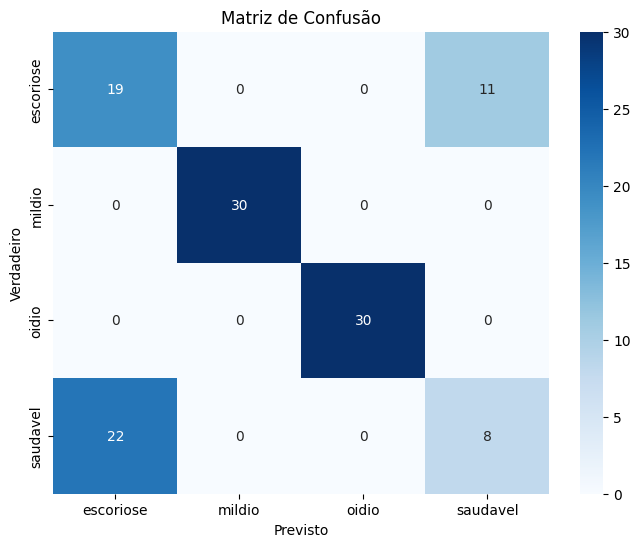

In [19]:
# 9. Matriz de confusão
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

In [20]:
# 10. Relatório de classificação
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

              precision    recall  f1-score   support

   escoriose       0.46      0.63      0.54        30
      mildio       1.00      1.00      1.00        30
       oidio       1.00      1.00      1.00        30
    saudavel       0.42      0.27      0.33        30

    accuracy                           0.72       120
   macro avg       0.72      0.72      0.72       120
weighted avg       0.72      0.72      0.72       120



In [ ]:
## 11. Conclusões e Análise dos Resultados

- O modelo de classificação de doenças em videiras, baseado numa CNN simples (3 camadas convolucionais), alcançou uma **acurácia global de 72%** no conjunto de teste equilibrado (120 imagens, 30 por classe).
- **Desempenho por classe:**
  - **Míldio e oídio** foram identificados com **100% de precisão e recall**, indicando que os sintomas gerados para estas doenças são visualmente distintos e o modelo aprendeu a reconhecê-los perfeitamente.
  - **Escoriose** apresentou um recall de 63% e precisão de 46%, sendo frequentemente confundida com **saudável** (22 dos 30 casos de escoriose foram classificados como saudáveis).
  - **Saudável** teve o pior desempenho (recall 27%), com 22 das 30 amostras saudáveis classificadas como escoriose.

- **Análise da matriz de confusão:** A confusão predominante entre escoriose e saudável sugere que as imagens sintéticas destas duas classes podem não ter diferenças suficientemente robustas, ou que os sintomas de escoriose (manchas escuras) são subtis e por vezes confundidos com variações naturais da folha saudável.

- **Evolução do treino:** A perda de treino diminuiu consistentemente, e a perda de validação estabilizou por volta da época 44, com o EarlyStopping a interromper o treino na época 54. O uso de ReduceLROnPlateau ajudou a afinar o modelo.

- **Limitações e próximos passos:**
  - Melhorar a geração de imagens para a classe **escoriose**, tornando os sintomas mais evidentes e variados.
  - Aumentar a base de dados para todas as classes (atualmente 200 por classe) para melhor generalização.
  - Experimentar técnicas de **data augmentation mais agressivas** e **transfer learning com modelos pré-treinados** (ex.: EfficientNet) para ver se melhoram a discriminação entre escoriose e saudável.
  - Considerar uma abordagem de **deteção de objetos** (YOLO) se houver interesse em localizar as lesões, em vez de apenas classificar a imagem inteira.

- **Conclusão final:** O modelo atual é eficaz para detetar míldio e oídio, mas necessita de refinamento para escoriose e para a classe saudável. Ainda assim, constitui uma base sólida para um sistema de alerta precoce em viticultura, demonstrando o potencial da visão computacional na monitorização de doenças.